In [1]:
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import sys

import pickle
from aemulusnu_massfunction.utils import *

In [2]:
box = 'Box_n50_0_1400'
curr_run_fname = '/oak/stanford/orgs/kipac/aemulus/aemulus_nu/%s/'%(box)
rockstar_dir = curr_run_fname+'output/rockstar/'

In [3]:
f = open(rockstar_dir+'savelist.txt', 'r')
savelist = f.read().split()
f.close()


In [4]:
N_snapshots = len(savelist)

print(N_snapshots)

SNAPSHOT_IDX=0

import pickle

NvMs = {}
f = open('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_M200b', 'r')
TMP=0
skips = 0
# gt200idxs = {}
for line in tqdm(f):

    #extract the masses and position of halos for a given snapshot 
    snapshot_mass = line.strip().split()
    snapshot_mass = np.array(snapshot_mass, dtype=np.float64)  
    print(len(snapshot_mass))

    
    #get the volume, redshift, and particle mass in the simulation
    vol = -1
    BOX_SIZE = -1
    a = -1
    Mpart = -1
    
    f_meta = open(rockstar_dir+'out_%d.list'%(SNAPSHOT_IDX), 'r')

    for meta_data in f_meta:
        if('#a' in meta_data):
            a = eval(meta_data.split()[2])
        if('Particle mass' in meta_data):
            Mpart = eval(meta_data.split()[2])
        if('Box size' in meta_data):
            vol = eval(meta_data.split()[2])**3
            BOX_SIZE = eval(meta_data.split()[2])
            break        
    print('redshift', scaleToRedshift(a))
    SNAPSHOT_IDX+=1
    if(scaleToRedshift(a) >= 2):
        skips+=1
        continue
    left_log10 = np.ceil(np.log10(200*Mpart) * 10) / 10 #e.g. 13.897234 -> 13.9
    print('leftlog10', left_log10)
    edges_log10 = np.arange(left_log10, 1+np.log10(np.max(snapshot_mass)), 0.1)
    edges = np.array([10**el10 for el10 in edges_log10])

    #get the number count of halos in the mass bins
    N, bin_edge, bin_idx = binned_statistic(snapshot_mass, np.ones_like(snapshot_mass), 
                                            statistic='count', bins=edges)
    print('sumN', sum(N))
    print('N', N)
    print('edges', np.log10(edges))
    c_i = len(N)-1
    while(N[c_i] == 0):
        N = N[:c_i]
        bin_edge = bin_edge[:(c_i+1)]
        c_i -= 1
        
    #make large mass bin have at least 20 halos
    while(N[c_i] < 20):
        N[c_i-1] += N[c_i]
        halos_here = np.where(bin_idx==c_i+1)
        bin_idx[halos_here] = c_i
        N = N[:c_i]
        bin_edge = np.delete(bin_edge,c_i)
        c_i -= 1
    print('after adaptive', N)
        
    M_means = []
    correction = np.zeros_like(N)
    
    for j in range(len(N)):
        this_bin = np.where(bin_idx == j+1)
        M_means += [np.mean(snapshot_mass[this_bin])]
#         print(N[j], len(snapshot_mass[this_bin]))
        assert(len(snapshot_mass[this_bin]) == N[j])
            
    edge_pairs = [[bin_edge[j], bin_edge[j+1]] for j in range(len(bin_edge)-1)]
    assert(len(edge_pairs) == len(N))
#     ax.bar(x=bin_edge[:-1], height=N, width=np.diff(bin_edge), align='edge', fill=False, label=r'$a=%.2f$'%(a))

#     ax.set_title(curr_run_fname.split('/')[-2])
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_xlabel(r'Mass $[h^{-1}M_\odot]$')
#     ax.set_ylabel(r'$N$')
#     ax.legend(frameon=False)

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/'+curr_run_fname.split('/')[-2]+'_NvsM_a%.1f.pdf'%(a), bbox_inches='tight')

    assert(len(edge_pairs) == len(N))
    NvMs[a] = {'M':M_means, 
               'N':N, 
               'vol':vol, 
               'Mpart':Mpart, 
               'edge_pairs':edge_pairs,
               'bin_idx':bin_idx,
               'corrections':correction}
f.close()

16


1it [00:00,  1.98it/s]

2948336
redshift 3.0


2it [00:01,  1.38it/s]

5062035
redshift 2.3038301302700224
7044910
redshift 1.7288182306888356
leftlog10 12.9


3it [00:02,  1.08s/it]

sumN 140551.0
N [4.6692e+04 3.3086e+04 2.2388e+04 1.4805e+04 9.5740e+03 5.9930e+03
 3.5660e+03 2.1170e+03 1.1880e+03 6.2600e+02 3.0900e+02 1.0800e+02
 6.1000e+01 2.0000e+01 1.2000e+01 3.0000e+00 3.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5]
after adaptive [4.6692e+04 3.3086e+04 2.2388e+04 1.4805e+04 9.5740e+03 5.9930e+03
 3.5660e+03 2.1170e+03 1.1880e+03 6.2600e+02 3.0900e+02 1.0800e+02
 6.1000e+01 3.8000e+01]
7844583
redshift 1.4800111104497748
leftlog10 12.9


4it [00:04,  1.32s/it]

sumN 204465.0
N [6.3473e+04 4.5957e+04 3.2410e+04 2.2242e+04 1.5079e+04 9.9040e+03
 6.4160e+03 3.8810e+03 2.4040e+03 1.3400e+03 6.8300e+02 3.9200e+02
 1.5400e+02 7.6000e+01 3.4000e+01 1.4000e+01 3.0000e+00 3.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6]
after adaptive [6.3473e+04 4.5957e+04 3.2410e+04 2.2242e+04 1.5079e+04 9.9040e+03
 6.4160e+03 3.8810e+03 2.4040e+03 1.3400e+03 6.8300e+02 3.9200e+02
 1.5400e+02 7.6000e+01 3.4000e+01 2.0000e+01]
8961173
redshift 1.0483786059144884
leftlog10 12.9


5it [00:06,  1.53s/it]

sumN 352729.0
N [9.5881e+04 7.3486e+04 5.4199e+04 3.9807e+04 2.8692e+04 2.0549e+04
 1.4093e+04 9.7160e+03 6.3790e+03 4.1330e+03 2.5870e+03 1.5050e+03
 8.2100e+02 4.5300e+02 2.3800e+02 1.1600e+02 4.3000e+01 1.7000e+01
 1.1000e+01 2.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9]
after adaptive [9.5881e+04 7.3486e+04 5.4199e+04 3.9807e+04 2.8692e+04 2.0549e+04
 1.4093e+04 9.7160e+03 6.3790e+03 4.1330e+03 2.5870e+03 1.5050e+03
 8.2100e+02 4.5300e+02 2.3800e+02 1.1600e+02 4.3000e+01 3.1000e+01]
9141194
redshift 0.9527626709887815
leftlog10 12.9


6it [00:08,  1.70s/it]

sumN 391100.0
N [1.03543e+05 7.96940e+04 5.94440e+04 4.42430e+04 3.24460e+04 2.34630e+04
 1.63980e+04 1.14060e+04 7.69800e+03 5.13200e+03 3.24600e+03 2.01600e+03
 1.08300e+03 6.46000e+02 3.27000e+02 1.81000e+02 8.40000e+01 2.50000e+01
 1.70000e+01 7.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9]
after adaptive [1.03543e+05 7.96940e+04 5.94440e+04 4.42430e+04 3.24460e+04 2.34630e+04
 1.63980e+04 1.14060e+04 7.69800e+03 5.13200e+03 3.24600e+03 2.01600e+03
 1.08300e+03 6.46000e+02 3.27000e+02 1.81000e+02 8.40000e+01 2.50000e+01
 2.50000e+01]
9287469
redshift 0.8616115226306804
leftlog10 12.9


7it [00:10,  1.78s/it]

sumN 428691.0
N [1.10294e+05 8.56020e+04 6.48010e+04 4.84020e+04 3.60160e+04 2.65160e+04
 1.86180e+04 1.33040e+04 9.11100e+03 6.23100e+03 3.95200e+03 2.57300e+03
 1.50800e+03 8.50000e+02 4.54000e+02 2.40000e+02 1.30000e+02 4.90000e+01
 2.40000e+01 1.00000e+01 6.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9]
after adaptive [1.10294e+05 8.56020e+04 6.48010e+04 4.84020e+04 3.60160e+04 2.65160e+04
 1.86180e+04 1.33040e+04 9.11100e+03 6.23100e+03 3.95200e+03 2.57300e+03
 1.50800e+03 8.50000e+02 4.54000e+02 2.40000e+02 1.30000e+02 4.90000e+01
 4.00000e+01]
9400575
redshift 0.7747142266416549
leftlog10 12.9


8it [00:12,  1.87s/it]

sumN 465606.0
N [1.16763e+05 9.10360e+04 6.99410e+04 5.26790e+04 3.94170e+04 2.92540e+04
 2.11340e+04 1.51260e+04 1.06200e+04 7.36100e+03 4.78500e+03 3.11100e+03
 1.98100e+03 1.09500e+03 6.47000e+02 3.38000e+02 1.68000e+02 8.70000e+01
 3.90000e+01 1.40000e+01 7.00000e+00 3.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16. ]
after adaptive [1.16763e+05 9.10360e+04 6.99410e+04 5.26790e+04 3.94170e+04 2.92540e+04
 2.11340e+04 1.51260e+04 1.06200e+04 7.36100e+03 4.78500e+03 3.11100e+03
 1.98100e+03 1.09500e+03 6.47000e+02 3.38000e+02 1.68000e+02 8.70000e+01
 3.90000e+01 2.40000e+01]
9485078
redshift 0.691872750866662
leftlog10 12.9


9it [00:14,  1.93s/it]

sumN 501979.0
N [1.23125e+05 9.67080e+04 7.40880e+04 5.67070e+04 4.29850e+04 3.20250e+04
 2.36870e+04 1.68850e+04 1.21500e+04 8.49700e+03 5.69800e+03 3.75500e+03
 2.46000e+03 1.43500e+03 8.38000e+02 4.77000e+02 2.44000e+02 1.21000e+02
 5.20000e+01 2.80000e+01 6.00000e+00 8.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16. ]
after adaptive [1.23125e+05 9.67080e+04 7.40880e+04 5.67070e+04 4.29850e+04 3.20250e+04
 2.36870e+04 1.68850e+04 1.21500e+04 8.49700e+03 5.69800e+03 3.75500e+03
 2.46000e+03 1.43500e+03 8.38000e+02 4.77000e+02 2.44000e+02 1.21000e+02
 5.20000e+01 4.20000e+01]
9543245
redshift 0.6128980229096033
leftlog10 12.9


10it [00:16,  1.98s/it]

sumN 537255.0
N [1.29118e+05 1.01637e+05 7.85840e+04 6.04770e+04 4.64120e+04 3.47970e+04
 2.58130e+04 1.88840e+04 1.37610e+04 9.62300e+03 6.57900e+03 4.46100e+03
 2.94900e+03 1.79500e+03 1.06300e+03 6.48000e+02 3.36000e+02 1.79000e+02
 7.80000e+01 3.60000e+01 1.40000e+01 7.00000e+00 4.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16.  16.1]
after adaptive [1.29118e+05 1.01637e+05 7.85840e+04 6.04770e+04 4.64120e+04 3.47970e+04
 2.58130e+04 1.88840e+04 1.37610e+04 9.62300e+03 6.57900e+03 4.46100e+03
 2.94900e+03 1.79500e+03 1.06300e+03 6.48000e+02 3.36000e+02 1.79000e+02
 7.80000e+01 3.60000e+01 2.50000e+01]
9581445
redshift 0.5376099391106464
leftlog10 12.9


11it [00:18,  2.03s/it]

sumN 570554.0
N [1.34205e+05 1.06434e+05 8.28470e+04 6.36600e+04 4.95580e+04 3.74580e+04
 2.79230e+04 2.09130e+04 1.53190e+04 1.08440e+04 7.49400e+03 5.13200e+03
 3.46100e+03 2.24100e+03 1.35000e+03 8.16000e+02 4.44000e+02 2.55000e+02
 1.05000e+02 5.90000e+01 2.10000e+01 1.00000e+01 5.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16.  16.1]
after adaptive [1.34205e+05 1.06434e+05 8.28470e+04 6.36600e+04 4.95580e+04 3.74580e+04
 2.79230e+04 2.09130e+04 1.53190e+04 1.08440e+04 7.49400e+03 5.13200e+03
 3.46100e+03 2.24100e+03 1.35000e+03 8.16000e+02 4.44000e+02 2.55000e+02
 1.05000e+02 5.90000e+01 3.60000e+01]
9598031
redshift 0.3974131088528914
leftlog10 12.9


12it [00:20,  2.05s/it]

sumN 632214.0
N [1.43111e+05 1.14161e+05 9.06420e+04 6.97630e+04 5.51500e+04 4.26480e+04
 3.23740e+04 2.42200e+04 1.82950e+04 1.32640e+04 9.47600e+03 6.48800e+03
 4.73300e+03 3.07400e+03 2.02000e+03 1.23500e+03 7.45000e+02 3.99000e+02
 2.20000e+02 1.19000e+02 4.40000e+01 1.90000e+01 8.00000e+00 5.00000e+00
 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16.  16.1 16.2 16.3]
after adaptive [1.43111e+05 1.14161e+05 9.06420e+04 6.97630e+04 5.51500e+04 4.26480e+04
 3.23740e+04 2.42200e+04 1.82950e+04 1.32640e+04 9.47600e+03 6.48800e+03
 4.73300e+03 3.07400e+03 2.02000e+03 1.23500e+03 7.45000e+02 3.99000e+02
 2.20000e+02 1.19000e+02 4.40000e+01 3.30000e+01]
9560827
redshift 0.26999931420037027
leftlog10 12.9


13it [00:23,  2.07s/it]

sumN 686763.0
N [1.50154e+05 1.21610e+05 9.62870e+04 7.52960e+04 5.98890e+04 4.67610e+04
 3.61800e+04 2.74550e+04 2.10380e+04 1.58340e+04 1.15600e+04 7.93800e+03
 5.74000e+03 4.07600e+03 2.72700e+03 1.75000e+03 1.11200e+03 6.34000e+02
 3.63000e+02 1.96000e+02 1.04000e+02 3.10000e+01 2.00000e+01 3.00000e+00
 3.00000e+00 2.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4]
after adaptive [1.50154e+05 1.21610e+05 9.62870e+04 7.52960e+04 5.98890e+04 4.67610e+04
 3.61800e+04 2.74550e+04 2.10380e+04 1.58340e+04 1.15600e+04 7.93800e+03
 5.74000e+03 4.07600e+03 2.72700e+03 1.75000e+03 1.11200e+03 6.34000e+02
 3.63000e+02 1.96000e+02 1.04000e+02 3.10000e+01 2.80000e+01]
9488332
redshift 0.15420262488760939
leftlog10 12.9


14it [00:25,  2.07s/it]

sumN 734813.0
N [1.56865e+05 1.26693e+05 1.01592e+05 7.98510e+04 6.39070e+04 5.04580e+04
 3.94630e+04 3.04140e+04 2.34840e+04 1.79010e+04 1.34120e+04 9.58400e+03
 6.78300e+03 5.00500e+03 3.45500e+03 2.30500e+03 1.55100e+03 9.58000e+02
 5.14000e+02 3.08000e+02 1.71000e+02 7.80000e+01 4.10000e+01 1.10000e+01
 5.00000e+00 2.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6]
after adaptive [1.56865e+05 1.26693e+05 1.01592e+05 7.98510e+04 6.39070e+04 5.04580e+04
 3.94630e+04 3.04140e+04 2.34840e+04 1.79010e+04 1.34120e+04 9.58400e+03
 6.78300e+03 5.00500e+03 3.45500e+03 2.30500e+03 1.55100e+03 9.58000e+02
 5.14000e+02 3.08000e+02 1.71000e+02 7.80000e+01 4.10000e+01 2.00000e+01]
9398656
redshift 0.04896

15it [00:27,  2.08s/it]

sumN 776466.0
N [1.61421e+05 1.32146e+05 1.05289e+05 8.39670e+04 6.74410e+04 5.36510e+04
 4.21380e+04 3.29930e+04 2.56260e+04 1.96880e+04 1.51900e+04 1.10680e+04
 7.96600e+03 5.87900e+03 4.20700e+03 2.92200e+03 1.92900e+03 1.27200e+03
 7.36000e+02 4.34000e+02 2.70000e+02 1.23000e+02 6.00000e+01 3.10000e+01
 1.20000e+01 5.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6]
after adaptive [1.61421e+05 1.32146e+05 1.05289e+05 8.39670e+04 6.74410e+04 5.36510e+04
 4.21380e+04 3.29930e+04 2.56260e+04 1.96880e+04 1.51900e+04 1.10680e+04
 7.96600e+03 5.87900e+03 4.20700e+03 2.92200e+03 1.92900e+03 1.27200e+03
 7.36000e+02 4.34000e+02 2.70000e+02 1.23000e+02 6.00000e+01 5.00000e+01]
9347294
redshift 0.0
lef

16it [00:29,  1.83s/it]

sumN 795090.0
N [1.63263e+05 1.34468e+05 1.07054e+05 8.57410e+04 6.86920e+04 5.50770e+04
 4.35890e+04 3.42390e+04 2.64350e+04 2.06900e+04 1.58210e+04 1.17580e+04
 8.57000e+03 6.26500e+03 4.62900e+03 3.20800e+03 2.16800e+03 1.45000e+03
 8.65000e+02 4.93000e+02 3.07000e+02 1.61000e+02 7.70000e+01 4.40000e+01
 1.60000e+01 7.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00]
edges [12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6
 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7]
after adaptive [1.63263e+05 1.34468e+05 1.07054e+05 8.57410e+04 6.86920e+04 5.50770e+04
 4.35890e+04 3.42390e+04 2.64350e+04 2.06900e+04 1.58210e+04 1.17580e+04
 8.57000e+03 6.26500e+03 4.62900e+03 3.20800e+03 2.16800e+03 1.45000e+03
 8.65000e+02 4.93000e+02 3.07000e+02 1.61000e+02 7.70000e+01 4.40000e+01
 2.60000

In [5]:
print(1)

1


In [12]:
jackknife = {}
f_pos = open('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_pos', 'r')
for _ in range(skips):
    f_pos.readline()
from random import random
for a in tqdm(NvMs):
    snapshot_pos  = f_pos.readline().strip().split(',')
    snapshot_pos  = [np.array(pos.split(), dtype=np.float32) for pos in snapshot_pos if pos != '']
    snapshot_pos  = np.array(snapshot_pos)

    N = NvMs[a]['N']
    vol = NvMs[a]['vol']
    bin_idx = NvMs[a]['bin_idx']
    correction = NvMs[a]['corrections']
    assert(len(bin_idx) == len(snapshot_pos))
    #now lets get to spatial jackknife
    N_DIVS = 8 #each axis is diided into N_DIVS parts so in total the box
               #is divided into N_DIVS**3 boxes

    #compute the size of each smaller cube
    ϵ = vol*10**(-6)
    cube_vol = (vol+ε) / N_DIVS**3 #need ϵ to properly handle halos directly on boundary 
    cube_size = np.cbrt(cube_vol)
    rescale_factor = N_DIVS**3/(N_DIVS**3-1)

    #compute the indices of the smaller cube that each point belongs to
    cube_indices = (snapshot_pos / cube_size).astype(int)
    
    
    
    
    #cube_indices has assignment of halo to 3d position of a voxel
    #ravel_multi_index indexes the voxels in 3D with a single integer
    cube_assignment = np.ravel_multi_index(cube_indices.T, (N_DIVS, N_DIVS, N_DIVS), order='F')
    
    
#     print(np.min(cube_assignment), np.max(cube_assignment))

#     plt.hist(cube_assignment, bins=range(min(cube_assignment), max(cube_assignment) + 2), align='left')
#     plt.show()
#     break
    
    jackknife_data = []

    for i in range(N_DIVS**3):
        current_cube = np.where(cube_assignment == i)
        curr_N = np.zeros_like(N)
        for halo in bin_idx[current_cube]:
            #bin_idx=1 corresponds to first bin 
            #bin_idx-1 = idx of bin
            if(halo==0):
                continue
            curr_N[halo-1] += 1
            
        if(random()> 0.98):
            print(curr_N)
#         break
        #get the histogram if we left out this sub-cube
        jackknife_data += [[a-b for (a,b) in zip(N, curr_N)]]

    print(np.array(jackknife_data).shape)
    jackknife_mean = np.mean(jackknife_data, axis=0)

    jackknife_data = np.array(jackknife_data) - jackknife_mean
    jackknife_data *= rescale_factor
#     jackknife_covariance = np.cov(jackknife_data.T)
    print(jackknife_data.T[0].shape )
    jackknife_covariance = [[rescale_factor * np.sum(jackknife_data.T[i] * jackknife_data.T[j], axis=0) for j in range(len(N))] for i in range(len(N))]
    jackknife_covariance = np.array(jackknife_covariance)
    
    print(jackknife_covariance.shape)
    
    jackknife[a] = [jackknife_data, jackknife_covariance]
    break
f_pos.close()

  0%|          | 0/14 [00:00<?, ?it/s]

[102.  71.  42.  28.  19.  12.   9.   8.   2.   1.   0.   0.   0.   0.]
[73. 61. 38. 26. 18.  5.  8.  3.  1.  0.  1.  0.  0.  0.]
[59. 53. 37. 20. 12.  9.  3.  2.  0.  1.  1.  0.  0.  0.]
[78. 54. 34. 43. 13. 10.  7.  0.  2.  0.  0.  1.  0.  0.]


  0%|          | 0/14 [00:14<?, ?it/s]

[73. 50. 38. 30. 18.  5.  9.  4.  1.  1.  1.  0.  0.  0.]
[84. 57. 34. 31. 14.  8.  7.  0.  3.  1.  0.  0.  1.  0.]
(512, 14)
(512,)
(14, 14)


In [19]:
def getJackCov(N_DIVS=8):
    print(N_DIVS)
    jackknife = {}
    f_pos = open('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_pos', 'r')
    for _ in range(skips):
        f_pos.readline()
    for a in tqdm(NvMs):
        snapshot_pos  = f_pos.readline().strip().split(',')
        snapshot_pos  = [np.array(pos.split(), dtype=np.float32) for pos in snapshot_pos if pos != '']
        snapshot_pos  = np.array(snapshot_pos)

        N = NvMs[a]['N']
        vol = NvMs[a]['vol']
        bin_idx = NvMs[a]['bin_idx']
        correction = NvMs[a]['corrections']
        assert(len(bin_idx) == len(snapshot_pos))
        #compute the size of each smaller cube
        ϵ = vol*10**(-6)
        cube_vol = (vol+ε) / N_DIVS**3 #need ϵ to properly handle halos directly on boundary 
        cube_size = np.cbrt(cube_vol)
        rescale_factor = N_DIVS**3/(N_DIVS**3-1)

        #compute the indices of the smaller cube that each point belongs to
        cube_indices = (snapshot_pos / cube_size).astype(int)

        #cube_indices has assignment of halo to 3d position of a voxel
        #ravel_multi_index indexes the voxels in 3D with a single integer
        cube_assignment = np.ravel_multi_index(cube_indices.T, (N_DIVS, N_DIVS, N_DIVS), order='F')
        jackknife_data = []

        for i in range(N_DIVS**3):
            current_cube = np.where(cube_assignment == i)
            curr_N = np.zeros_like(N)
            for halo in bin_idx[current_cube]:
                #bin_idx=1 corresponds to first bin 
                #bin_idx-1 = idx of bin
                if(halo==0):
                    continue
                curr_N[halo-1] += 1
            #get the histogram if we left out this sub-cube
            jackknife_data += [[a-b for (a,b) in zip(N, curr_N)]]

        jackknife_mean = np.mean(jackknife_data, axis=0)

        jackknife_data = np.array(jackknife_data) - jackknife_mean
        #arxiv: 0408569 eqn 6
        jackknife_covariance = [[rescale_factor * np.sum(jackknife_data.T[i] * jackknife_data.T[j], axis=0) for j in range(len(N))] for i in range(len(N))]
        jackknife_covariance = np.array(jackknife_covariance)

        jackknife[a] = [jackknife_data, jackknife_covariance]
        return jackknife_covariance
        break
    f_pos.close()

In [31]:
from concurrent.futures import ProcessPoolExecutor
import numpy as np

# Create a pool of workers, equal to the number of cores you have (32 in your case)
with ProcessPoolExecutor(max_workers=32) as executor:
    # Use the executor to map the getJackCov function over your range of inputs
    tmp_jacks = list(executor.map(getJackCov, 2 ** (np.arange(6)+1)))


4232816




64


  0%|          | 0/14 [18:53<?, ?it/s]


In [32]:
a0 = -1
for a in tqdm(NvMs):
    a0 = a
    break

  0%|          | 0/14 [00:00<?, ?it/s]


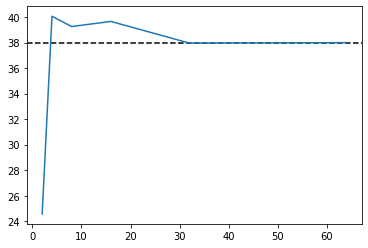

In [33]:
plt.axhline((NvMs[a0]['N'][-1]), linestyle='--', color='k')
final_elem = [tmp_jack[-1][-1] for tmp_jack in tmp_jacks]
plt.plot(2 ** (np.arange(6)+1),final_elem)